In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tqdm.notebook import tqdm

import sys
sys.path.insert(0, '../modules')
# Function to compute an error in L2 norm
#from norms import l2_diff

%matplotlib inline

plt.style.use('seaborn-v0_8-darkgrid')

def l2_diff(f1, f2):
    """
    Computes the l2-norm of the difference
    between a function f1 and a function f2
    
    Parameters
    ----------
    f1 : array of floats
        function 1
    f2 : array of floats
        function 2
    
    Returns
    -------
    diff : float
        The l2-norm of the difference.
    """
    l2_diff = np.sqrt(np.sum((f1 - f2)**2))/f1.shape[0]
    
    return l2_diff


def p_exact_2d(X, Y):
    """Computes the exact solution of the Poisson equation in the domain
    [0, 1]x[-0.5, 0.5] with rhs:
    b = (np.sin(np.pi * X) * np.cos(np.pi * Y) +
    np.sin(5.0 * np.pi * X) * np.cos(5.0 * np.pi * Y))

    Parameters
    ----------
    X : numpy.ndarray
        array of x coordinates for all grid points
    Y : numpy.ndarray
        array of y coordinates for all grid points

    Returns
    -------
    sol : numpy.ndarray
        exact solution of the Poisson equation
    """

    sol = (-1.0/(2.0*np.pi**2)*np.sin(np.pi*X)*np.cos(np.pi*Y)
        - 1.0/(50.0*np.pi**2)*np.sin(5.0*np.pi*X)*np.cos(5.0*np.pi*Y))

    return sol


In [90]:
# Grid parameters.
nx = 101                  # number of points in the x direction
ny = 101                  # number of points in the y direction
xmin, xmax = 0.0, 1.0     # limits in the x direction
ymin, ymax = -0.5, 0.5    # limits in the y direction
lx = xmax - xmin          # domain length in the x direction
ly = ymax - ymin          # domain length in the y direction
dx = lx / (nx-1)          # grid spacing in the x direction
dy = ly / (ny-1)          # grid spacing in the y direction

In [91]:
# Create the gridline locations and the mesh grid;
# see notebook 02_02_Runge_Kutta for more details
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
# We pass the argument `indexing='ij'` to np.meshgrid
# as x and y should be associated respectively with the
# rows and columns of X, Y.
X, Y = np.meshgrid(x, y, indexing='ij')

# Compute the rhs. Note that we non-dimensionalize the coordinates
# x and y with the size of the domain in their respective dire-
# ctions.
b = (np.sin(np.pi*X)*np.cos(np.pi*Y)
  + np.sin(5.0*np.pi*X)*np.cos(5.0*np.pi*Y))

# b is currently a 2D array. We need to convert it to a column-major
# ordered 1D array. This is done with the flatten numpy function.
# We use the parameter 'F' to specify that we want want column-major
# ordering. The letter 'F' is used because this is the natural
# ordering of the popular Fortran language. For row-major
# ordering you can pass 'C' as paremeter, which is the natural
# ordering for the C language.
# More info
# https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html
bflat = b[1:-1, 1:-1].flatten('F')

# Allocate array for the (full) solution, including boundary values
p = np.empty((nx, ny))
p0 = np.zeros((nx, ny))
pnew = p0.copy()

# Compute the exact solution
p_e = p_exact_2d(X, Y)

In [92]:
for j in range(1, ny-1):
        for i in range(1, nx-1):
            pnew[i, j] = (0.25 * (p[i-1, j]+p[i+1, j]+p[i, j-1]
                       + p[i, j+1]-b[i, j]*dx**2))

In [93]:
tolerance = 1e-9
max_iter = 10000

p0 = np.zeros((nx, ny))
pnew = p0.copy()

In [94]:
pbar = tqdm(total=max_iter)
pbar.set_description("it / max_it")

it = 0 # iteration counter
diff = 1.0
tol_hist_gs = []
while (diff > tolerance):
    if it > max_iter:
        print('\nSolution did not converged within the maximum'
              ' number of iterations'
              f'\nLast l2_diff was: {diff:.5e}')
        break

    np.copyto(p, pnew)

    # We only modify interior nodes. The boundary nodes remain equal to
    # zero and the Dirichlet boundary conditions are therefore automatically
    # enforced.
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            pnew[i, j] = (0.25 * (pnew[i-1, j]+p[i+1, j]+pnew[i, j-1]
                       + p[i, j+1]-b[i, j]*dx**2))

    diff = l2_diff(pnew, p)
    tol_hist_gs.append(diff)

    it += 1
    pbar.update(1)


else:
    print(f'\nThe solution converged after {it} iterations')



  0%|          | 0/10000 [00:00<?, ?it/s]


Solution did not converged within the maximum number of iterations
Last l2_diff was: 1.27850e-09


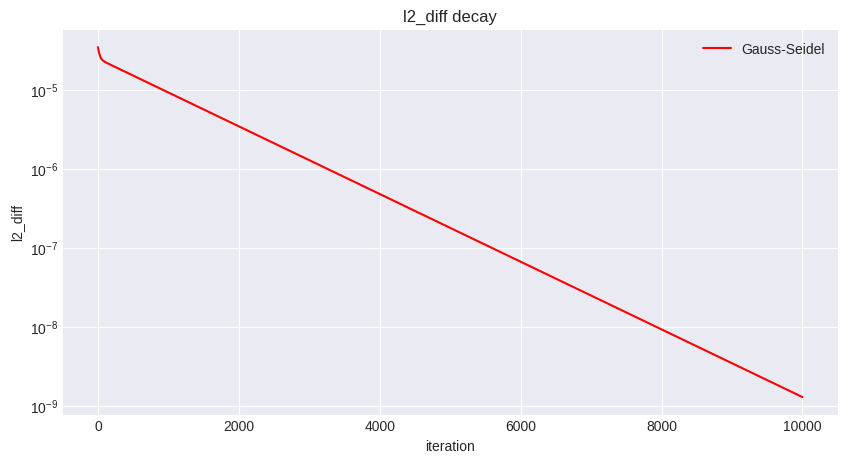

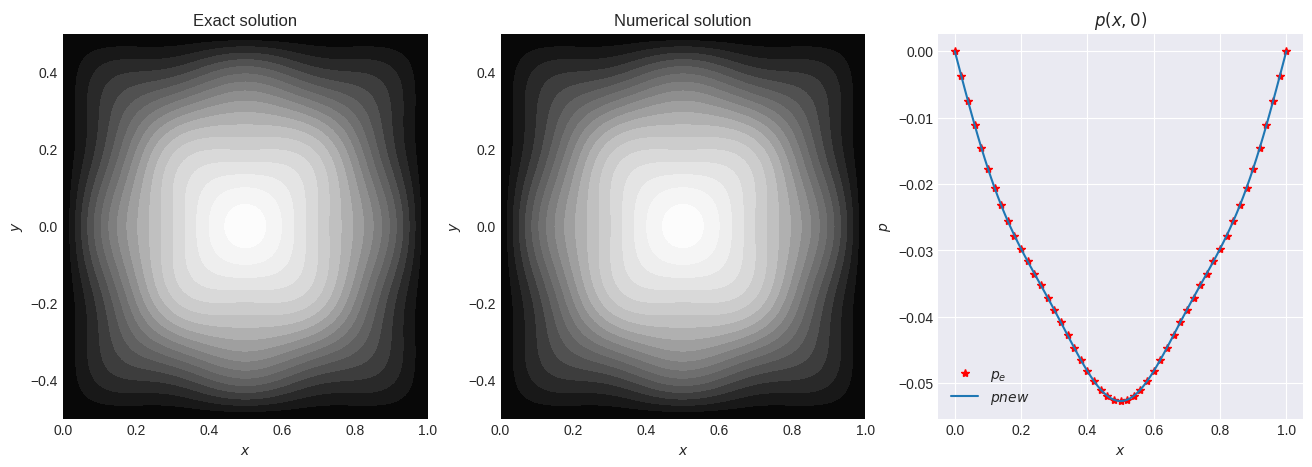

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.semilogy(tol_hist_jac, label='Jacobi')
ax.semilogy(tol_hist_gs, color='red', label='Gauss-Seidel')


# We set labels of x axis and y axis.
ax.set_xlabel('iteration')
ax.set_ylabel('l2_diff')
ax.set_title('l2_diff decay')
ax.legend()

fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
# We shall now use the
# matplotlib.pyplot.contourf function.
# As X and Y, we pass the mesh data.
#
# For more info
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html
#
ax_1.contourf(X, Y, pnew, 20)
ax_2.contourf(X, Y, p_e, 20)

# plot along the line y=0:
jc = int(ly/(2*dy))
ax_3.plot(x, p_e[:,jc], '*', color='red', markevery=2, label=r'$p_e$')
ax_3.plot(x, pnew[:,jc], label=r'$pnew$')

# add some labels and titles
ax_1.set_xlabel(r'$x$')
ax_1.set_ylabel(r'$y$')
ax_1.set_title('Exact solution')

ax_2.set_xlabel(r'$x$')
ax_2.set_ylabel(r'$y$')
ax_2.set_title('Numerical solution')

ax_3.set_xlabel(r'$x$')
ax_3.set_ylabel(r'$p$')
ax_3.set_title(r'$p(x,0)$')

ax_3.legend()

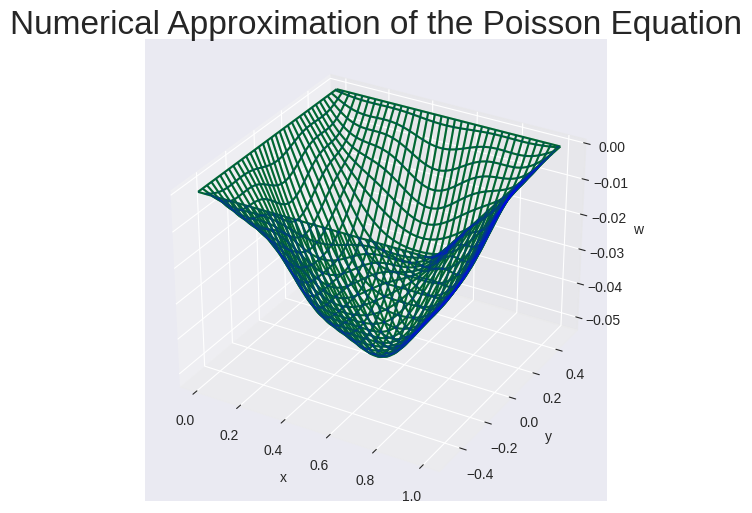

In [96]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wirefram) solution, including boundary valuese.
ax.plot_wireframe(X, Y, pnew,color='g')
ax.plot_wireframe(X, Y, p_e,color='b', alpha=0.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')

plt.title(r'Numerical Approximation of the Poisson Equation',fontsize=24,y=1.08)
plt.show()

In [97]:
#not sure how to do boundary conditions
#this code is only for the Dirichlet boundary conditions rn?

def d2_mat_dirichlet_2d(nx, ny, dx, dy):
    """
    Constructs the matrix for the centered second-order accurate
    second-order derivative for Dirichlet boundary conditions in 2D

    Parameters
    ----------
    nx : integer
        number of grid points in the x direction
    ny : integer
        number of grid points in the y direction
    dx : float
        grid spacing in the x direction
    dy : float
        grid spacing in the y direction

    Returns
    -------
    d2mat : numpy.ndarray
        matrix to compute the centered second-order accurate first-order deri-
        vative with Dirichlet boundary conditions
    """
    a = 1.0 / dx**2
    g = 1.0 / dy**2
    c = -2.0*a - 2.0*g

    diag_a = a * np.ones((nx-2)*(ny-2)-1)
    diag_a[nx-3::nx-2] = 0.0
    diag_g = g * np.ones((nx-2)*(ny-3))
    diag_c = c * np.ones((nx-2)*(ny-2))

    # We construct a sequence of main diagonal elements,
    diagonals = [diag_g, diag_a, diag_c, diag_a, diag_g]
    # and a sequence of positions of the diagonal entries relative to the main
    # diagonal.
    offsets = [-(nx-2), -1, 0, 1, nx-2]

    # Call to the diags routine; note that diags return a representation of the
    # array; to explicitly obtain its ndarray realisation, the call to .toarray()
    # is needed. Note how the matrix has dimensions (nx-2)*(nx-2).
    d2mat = diags(diagonals, offsets).toarray()

    # Return the final array
    return d2mat